In [1]:
import optuna

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

import idlmam

In [2]:
if torch.backends.mps.is_available(): 
    device = torch.device("mps") 
else:
    device = torch.device("cpu")

In [3]:
train_data = torchvision.datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), download=True) 
test_data = torchvision.datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=128)

In [4]:
W, H = 28, 28 # Width and Height of the image
D = 28 * 28   # Dimension of the image
n = 256       # Number of neurons in the hidden layer
C = 1         # Number of channels

n_filters = 32

classes = 10

In [5]:
leak_rate = 0.1

In [6]:
loss_func = nn.CrossEntropyLoss() 

In [7]:
class SkipFC(nn.Module):
    def __init__(self, n_layers, in_size, out_size, leak_rate=0.1):
        """
        n_layers: how many hidden layers for this block of dense skip connections
        in_size: how many features are coming into this layer
        out_size: how many features should be used for the final layer of this block.  
        leak_rate: the parameter for the LeakyReLU activation function. 
        """
        super().__init__()
        
        #The final layer will be treated differently, so lets grab it's index to use in the next two lines
        l = n_layers-1
        #The linear and batch norm layers are stored in `layers` and `bns` respectively. A list comprehensive creates all the layers in one line each. The `if i == l` allows us to single out the last layer which needs to use `out_size` instead of `in_size`
        self.layers = nn.ModuleList([nn.Linear(in_size*l, out_size) if i == l else nn.Linear(in_size, in_size) for i in range(n_layers)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(out_size) if i == l else nn.BatchNorm1d(in_size) for i in range(n_layers)])
        #Since we are writing our own `forward` function instead of using nn.Sequential, we can just use one activation object multiple times. 
        self.activation = nn.LeakyReLU(leak_rate)
    
    def forward(self, x):
        #First we need a location to store the activations from every layer (except the last one) in this block. All the activations will be combined as the input to the last layer, which is what makes the skips! 
        activations = []
        
        #zip the linear and normalization layers into paired tuples, using [:-1] to select all but the last item in each list.
        for layer, bn in zip(self.layers[:-1], self.bns[:-1]):
            x = self.activation(bn(layer(x)))
            activations.append( x )
        #concatenate the activations together, this makes the input for the last layer
        x = torch.cat(activations, dim=1)
        #Now manually use the last linear and batch-norm layer on this concatenated input, giving us the result.
        return self.activation(self.bns[-1](self.layers[-1](x)))

In [8]:
fc_skip_model = nn.Sequential(
    nn.Flatten(),
    SkipFC(2, D, n),
    SkipFC(2, n, n),
    SkipFC(2, n, n),
    nn.Linear(n, classes),
)

fc_skip_results = idlmam.train_network(fc_skip_model, loss_func, train_loader, test_loader=test_loader, epochs=10, score_funcs={'Accuracy': accuracy_score}, device=device)
del fc_skip_model

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Skip connection for the CNN

In [9]:
class SkipConv2d(nn.Module):
    def __init__(self, n_layers, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        
        #The last convolution will have a different number of inputs and output channels, so we still need that index
        l = n_layers-1
        #this is just simple helper values 
        f = (kernel_size, kernel_size)
        pad = (kernel_size-1)//2
        
        #Defining the layers used, altering the construction of the last layer using the same `if i == l` list comprehension. We are going to combine convolutions via their channels, so the in and out channels change for the last layer.  
        self.layers = nn.ModuleList([nn.Conv2d(in_channels*l, out_channels, kernel_size=f, padding=pad) if i == l else nn.Conv2d(in_channels, in_channels, kernel_size=f, padding=pad) for i in range(n_layers)])
        self.bns = nn.ModuleList([nn.BatchNorm2d(out_channels) if i == l else nn.BatchNorm2d(in_channels) for i in range(n_layers)])
        
        self.activation = nn.LeakyReLU(leak_rate)
    
    def forward(self, x):
        #This code is identical to the SkipFC class, but its worth highliting the most important line that could change. 
        activations = []
        
        for layer, bn in zip(self.layers[:-1], self.bns[:-1]):
            x = self.activation(bn(layer(x)))
            activations.append( x )
        #Which is the concatination of all the activations here. Our tensors are organized as (B, C, W, H), which is the default in PyTorch. But you can change that, and sometimes people use (B, W, H, C). In that situation the C channel is at index 3 instead of 1. So you would change `cat=3` in that scenario. This is also how you would adapt this code to work with RNNs
        x = torch.cat(activations, dim=1)
        
        return self.activation(self.bns[-1](self.layers[-1](x)))

In [10]:
cnn_skip_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1), 
    SkipConv2d(3, n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(),
    SkipConv2d(3, 2*n_filters, 4*n_filters),
    nn.MaxPool2d((2,2)),
    SkipConv2d(2, 4*n_filters, 4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

cnn_skip_results = idlmam.train_network(cnn_skip_model, loss_func, train_loader, test_loader=test_loader, epochs=10, score_funcs={'Accuracy': accuracy_score}, device=device)
del cnn_skip_model

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Info share block

In [11]:
def infoShareBlock(n_filters): 
    return nn.Sequential(
        nn.Conv2d(n_filters, n_filters, (1,1), padding=0), 
        nn.BatchNorm2d(n_filters), 
        nn.LeakyReLU())

In [12]:
def cnnLayer(in_filters, out_filters=None, kernel_size=3):
    if out_filters is None:
        out_filters = in_filters #This is a common pattern, so lets automate it as a default if not asked
    padding=kernel_size//2 #padding to stay the same size
    return nn.Sequential( # Combine the layer and activation into a single unit
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters), #The only change, adding BatchNorm2d after our convolution! 
        nn.LeakyReLU(leak_rate)
    )

In [13]:
cnn_1x1_model = nn.Sequential(
    cnnLayer(C, n_filters), 
    cnnLayer(n_filters),
    infoShareBlock(n_filters), #first info block after 2x cnnLayers
    cnnLayer(n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters), 
    cnnLayer(2*n_filters),
    infoShareBlock(2*n_filters),
    cnnLayer(2*n_filters), 
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters), 
    cnnLayer(4*n_filters),
    infoShareBlock(4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)
#Now train up this model
cnn_1x1_results = idlmam.train_network(cnn_1x1_model, loss_func, train_loader, test_loader=test_loader, epochs=10, score_funcs={'Accuracy': accuracy_score}, device=device)
del cnn_1x1_model

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

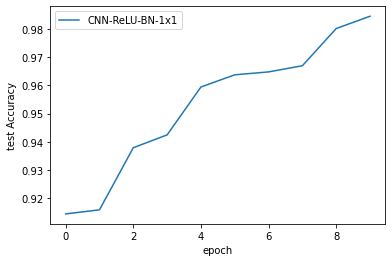

In [14]:
# sns.lineplot(x='epoch', y='test Accuracy', data=cnn_relu_results, label='CNN-ReLU')
# sns.lineplot(x='epoch', y='test Accuracy', data=cnn_bn_results, label='CNN-ReLU-BN')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_1x1_results, label='CNN-ReLU-BN-1x1')

If we combine skip and 1 x 1 convs we get residual connection

In [15]:
class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        """
        channels: how many channels are in the input/output to this layer
        kernel_size: how large of a filter should we use
        leak_rate: paramter for the LeakyReLU activation function
        """
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        
        #Define the conv an BN layers we will use in a sub-network, just 2 hidden layers of conv/BN/activation
        self.F = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
        )
     
    def forward(self, x):
        return x + self.F(x) #F() has all the work for the long path, we just add it to the input


We also need a way to handle different numbers of channels after we do pooling. 

That's what residual bottlenecks are for

In [16]:
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        #The botteneck should be smaller, so output/4 or input. You could also try changing max to min, its not a major issue. 
        bottleneck = max(out_channels//4, in_channels)
        #Define the three sets of BN and convolution layers we need. 
        #Notice that for the 1x1 convs we use padding=0, because 1x1 will not change shape! 
        self.F = nn.Sequential(
            #Compress down
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
            #Normal layer doing a full conv
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            #Expand back up
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0)
        )

        #By default, our shortcut will be the identiy function - which simply returns the input as the output
        self.shortcut = nn.Identity()
        #If we need to change the shape, then lets turn the shortcut into a small layer with 1x1 conv and BM
        if in_channels != out_channels:
            self.shortcut =  nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, padding=0), 
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        # shortcut(x) plays the role of "x", do as little work as possible to keep the tensor shapes the same.
        return self.shortcut(x) + self.F(x) 

In [17]:
cnn_res_model = nn.Sequential(
    ResidualBottleNeck(C, n_filters), #BottleNeck to start because we need more channels. Its also common to start with just one normal hidden layer before starting residual blocks. 
    nn.LeakyReLU(leak_rate), #We are inserting a activation after each residual. This is optional. 
    ResidualBlockE(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(n_filters, 2*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(2*n_filters, 4*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(4*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [18]:
cnn_res_results = idlmam.train_network(cnn_res_model, 
                                loss_func, 
                                train_loader, 
                                test_loader=test_loader, 
                                epochs=10, 
                                score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/469 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

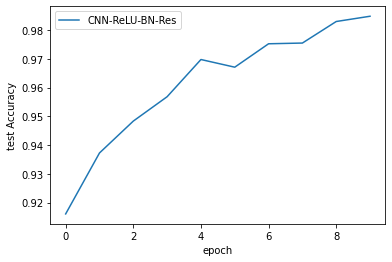

In [19]:
sns.lineplot(x='epoch', y='test Accuracy', 
             data=cnn_res_results, 
             label='CNN-ReLU-BN-Res')